In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [3]:
df_train= pd.read_csv('Train_HR_Employee_Attrition_New.csv')

In [4]:
df_test= pd.read_csv('Test_HR_Employee_Attrition_New.csv')

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1176 non-null   float64
 1   Attrition              1176 non-null   object 
 2   BusinessTravel         1176 non-null   object 
 3   DistanceFromHome       1176 non-null   int64  
 4   Education              1176 non-null   int64  
 5   EducationField         1176 non-null   object 
 6   Gender                 1176 non-null   object 
 7   JobRole                1176 non-null   object 
 8   MaritalStatus          1176 non-null   object 
 9   MonthlyIncome          1176 non-null   float64
 10  OverTime               1176 non-null   object 
 11  PercentSalaryHike      1176 non-null   int64  
 12  PerformanceRating      1176 non-null   float64
 13  StockOptionLevel       1176 non-null   int64  
 14  TotalWorkingYears      1176 non-null   int64  
 15  Trai

# ENCODING

In [7]:
df_train['EducationField'].value_counts()

Life Sciences       489
Medical             370
Marketing           125
Technical Degree    107
Other                64
Human Resources      21
Name: EducationField, dtype: int64

In [8]:
df_test['EducationField'].value_counts()

Life Sciences       117
Medical              94
Marketing            34
Technical Degree     25
Other                18
Human Resources       6
Name: EducationField, dtype: int64

In [9]:
label_encoders = dict()
column2encode = ['Attrition','BusinessTravel','EducationField','Gender',
                 'JobRole','MaritalStatus','OverTime']

for col in column2encode:
    le = LabelEncoder()
    le.fit(df_train[col])
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])
    label_encoders[col] = le

In [10]:
label_encoders['EducationField'].classes_

array(['Human Resources', 'Life Sciences', 'Marketing', 'Medical',
       'Other', 'Technical Degree'], dtype=object)

In [11]:
df_train['EducationField'].value_counts()

1    489
3    370
2    125
5    107
4     64
0     21
Name: EducationField, dtype: int64

In [12]:
df_test['EducationField'].value_counts()

1    117
3     94
2     34
5     25
4     18
0      6
Name: EducationField, dtype: int64

# SPLIT DATASET

In [13]:
df_train.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education',
       'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsInCurrentRole', 'ChangeCompanyRate', 'Satisfaction'],
      dtype='object')

In [14]:
attributes=[]
for col in df_train.columns:
    if (col!='Attrition'):
        attributes.append(col)
attributes

['Age',
 'BusinessTravel',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'MonthlyIncome',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsInCurrentRole',
 'ChangeCompanyRate',
 'Satisfaction']

In [15]:
X_train=df_train[attributes].values
Y_train=df_train['Attrition']

In [16]:
X_test=df_test[attributes].values
Y_test=df_test['Attrition']

In [17]:
Y_train.count()

1176

In [18]:
Y_train.value_counts()

0    984
1    192
Name: Attrition, dtype: int64

In [19]:
Y_test.value_counts()

0    249
1     45
Name: Attrition, dtype: int64

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix


In [22]:
import pydotplus
from sklearn import tree
from IPython.display import Image

In [23]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_accuracy'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation F1: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_f1'][candidate],
                  results['std_test_f1'][candidate]))
            print("Mean validation Balanced Accuracy: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_accuracy'][candidate],
                  results['std_test_accuracy'][candidate]))
            print("Mean validation Roc: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_auc'][candidate],
                  results['std_test_auc'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# PARAMETER TUNING

In [87]:
param_list = {'max_depth': list(np.arange(2, 20)),
              'min_samples_split': [2, 5] + list(np.arange(10, 100, 10)),
              'min_samples_leaf': [1, 5] + list(np.arange(10, 100, 10)),
              'criterion':['gini','entropy']
             }

scoring= {'auc':'roc_auc', 'accuracy':'balanced_accuracy', 'f1':'f1'}

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, class_weight='balanced')

In [124]:
random_search = RandomizedSearchCV(clf, param_distributions=param_list, scoring=scoring,
                                   refit='f1', n_iter=200, cv=10)
random_search.fit(X_train, Y_train)
clf = random_search.best_estimator_

In [125]:
report(random_search.cv_results_, n_top=5)

Model with rank: 1
Mean validation F1: 0.479 (std: 0.070)
Mean validation Balanced Accuracy: 0.719 (std: 0.058)
Mean validation Roc: 0.738 (std: 0.063)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 3, 'criterion': 'gini'}

Model with rank: 2
Mean validation F1: 0.464 (std: 0.059)
Mean validation Balanced Accuracy: 0.718 (std: 0.054)
Mean validation Roc: 0.730 (std: 0.062)
Parameters: {'min_samples_split': 70, 'min_samples_leaf': 40, 'max_depth': 4, 'criterion': 'gini'}

Model with rank: 3
Mean validation F1: 0.454 (std: 0.058)
Mean validation Balanced Accuracy: 0.717 (std: 0.052)
Mean validation Roc: 0.733 (std: 0.068)
Parameters: {'min_samples_split': 70, 'min_samples_leaf': 20, 'max_depth': 6, 'criterion': 'gini'}

Model with rank: 4
Mean validation F1: 0.457 (std: 0.060)
Mean validation Balanced Accuracy: 0.714 (std: 0.054)
Mean validation Roc: 0.743 (std: 0.054)
Parameters: {'min_samples_split': 30, 'min_samples_leaf': 50, 'max_depth': 15, 'criterion': '

In [88]:
param_list = {'max_depth': list(np.arange(2, 12)),
              'min_samples_split': list(np.arange(10, 50, 5)),
              'min_samples_leaf': list(np.arange(10, 50, 5)),
              'criterion':['gini','entropy']
             }

In [89]:
grid_search = GridSearchCV(clf, param_grid=param_list, scoring=scoring,
                                   refit='accuracy', cv=StratifiedKFold(15))
grid_search.fit(X_train, Y_train)
clf = grid_search.best_estimator_

In [90]:
report(grid_search.cv_results_, n_top=5)

Model with rank: 1
Mean validation F1: 0.508 (std: 0.115)
Mean validation Balanced Accuracy: 0.744 (std: 0.091)
Mean validation Roc: 0.764 (std: 0.086)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 40, 'min_samples_split': 10}

Model with rank: 1
Mean validation F1: 0.508 (std: 0.115)
Mean validation Balanced Accuracy: 0.744 (std: 0.091)
Mean validation Roc: 0.764 (std: 0.086)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 40, 'min_samples_split': 15}

Model with rank: 1
Mean validation F1: 0.508 (std: 0.115)
Mean validation Balanced Accuracy: 0.744 (std: 0.091)
Mean validation Roc: 0.764 (std: 0.086)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 40, 'min_samples_split': 20}

Model with rank: 1
Mean validation F1: 0.508 (std: 0.115)
Mean validation Balanced Accuracy: 0.744 (std: 0.091)
Mean validation Roc: 0.764 (std: 0.086)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 40, 'min_samples_split

In [84]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=5,
                             min_samples_leaf=10, class_weight='balanced')

In [85]:
clf = clf.fit(X_train, Y_train)

In [86]:
for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

Age 0.040963709465092604
BusinessTravel 0.0
DistanceFromHome 0.06599270953549495
Education 0.0
EducationField 0.048531044479516304
Gender 0.0
JobRole 0.0
MaritalStatus 0.02437753739120366
MonthlyIncome 0.0
OverTime 0.22313064363052468
PercentSalaryHike 0.0035870630709379445
PerformanceRating 0.0
StockOptionLevel 0.09144901629882579
TotalWorkingYears 0.22946276326095136
TrainingTimesLastYear 0.0
YearsInCurrentRole 0.023485677170356063
ChangeCompanyRate 0.04204485859112535
Satisfaction 0.20697497710597137


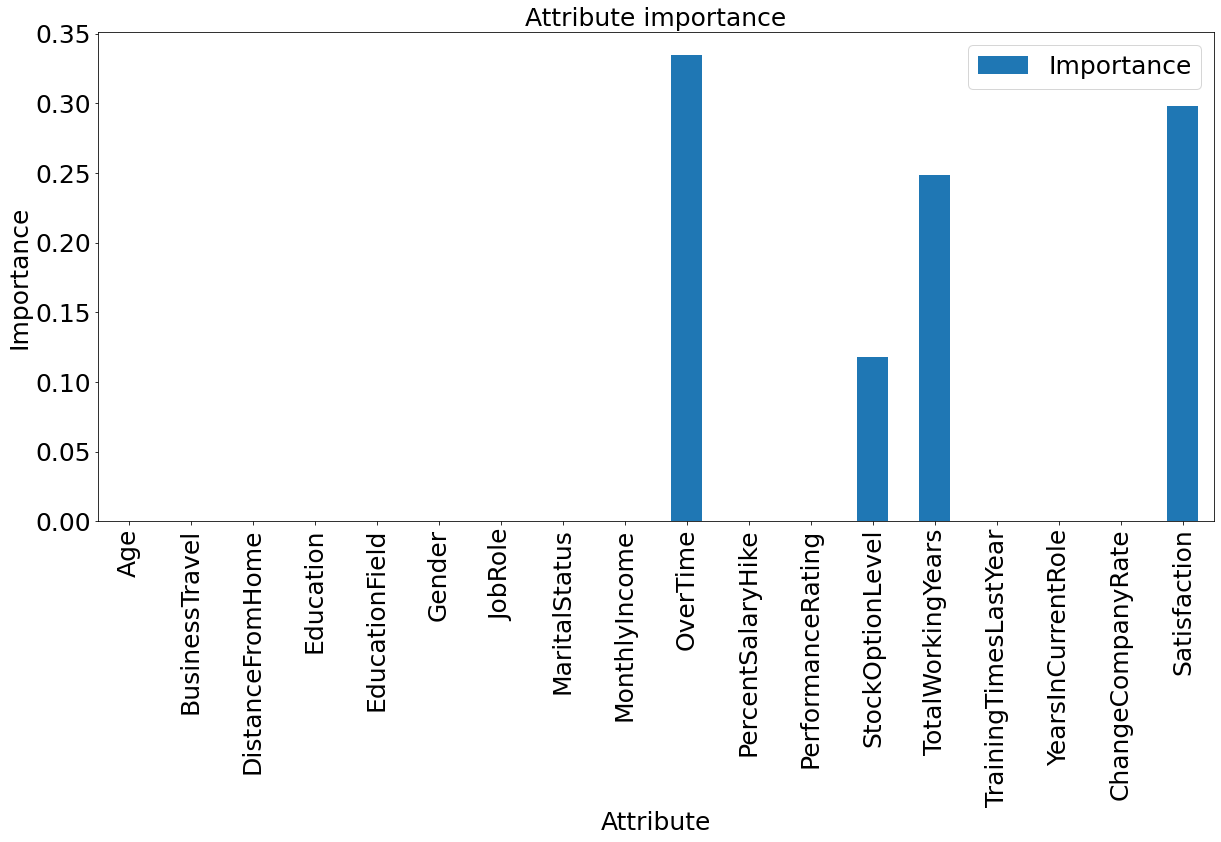

In [71]:
SMALL_SIZE = 25
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)
# fontsize of the figure title
df_imp=pd.DataFrame(columns=['Attribute', 'Importance'])
df_imp['Attribute']=attributes
df_imp['Importance']=clf.feature_importances_
df_imp.plot(kind='bar', title='Attribute importance', x='Attribute', y='Importance', figsize=(20, 9))
plt.xlabel('Attribute')
plt.ylabel('Importance')
plt.show()

In [72]:
df_imp

,Attribute,Importance
0,Age,0.000000
1,BusinessTravel,0.000000
2,DistanceFromHome,0.000000
3,Education,0.000000
4,EducationField,0.000000
5,Gender,0.000000
6,JobRole,0.000000
7,MaritalStatus,0.000000
8,MonthlyIncome,0.000000
9,OverTime,0.334561


In [32]:
import pydotplus
from sklearn import tree
from IPython.display import Image

In [33]:
import os
os.environ['PATH'] += os.pathsep + 'C:/Users/polpo/Anaconda3/Library/bin/graphviz'

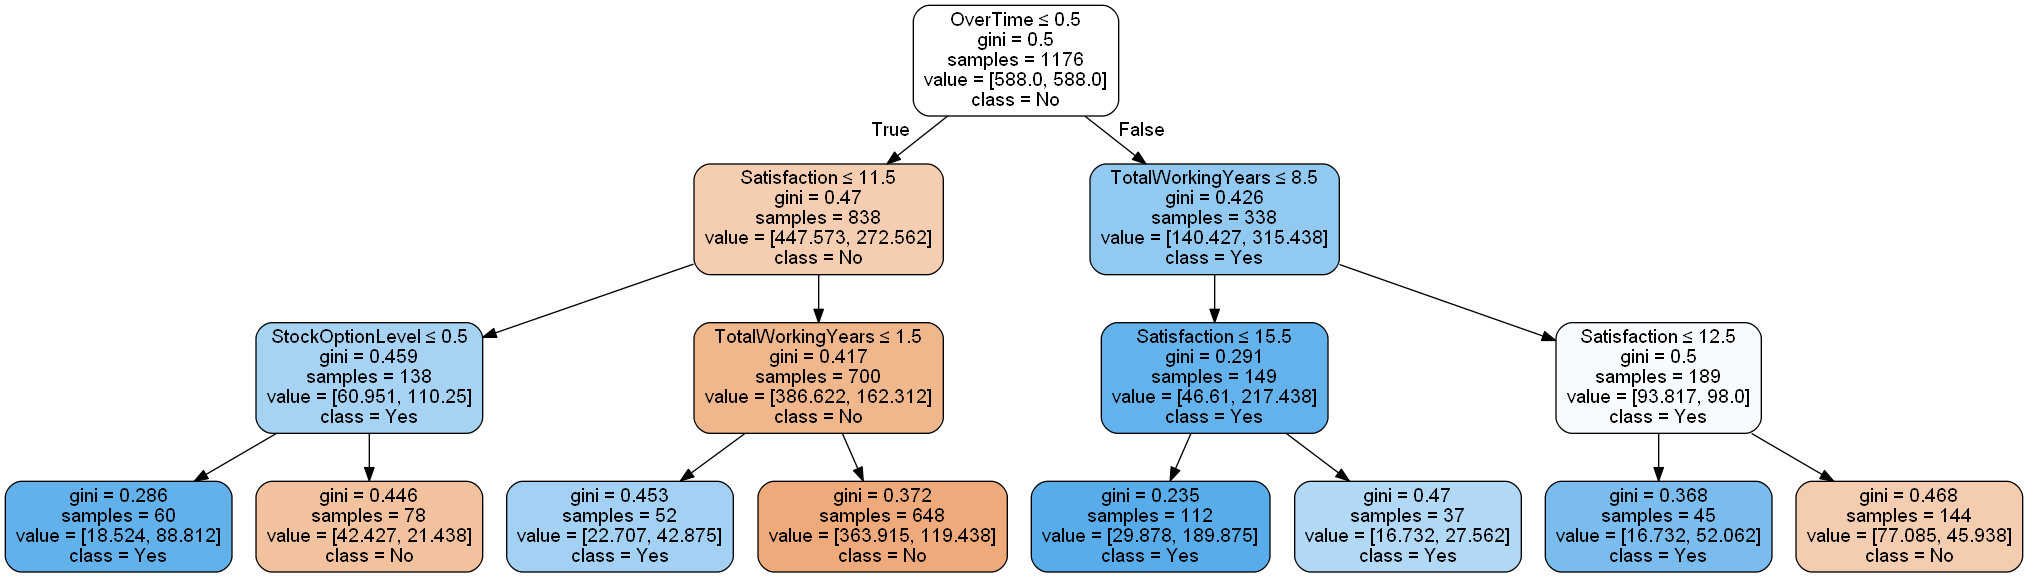

In [34]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=attributes,
                                class_names=['Yes' if x == 1 else 'No' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [82]:
Y_pred_tr = clf.predict(X_train)

In [132]:
print('Accuracy %s' % balanced_accuracy_score(Y_train, Y_pred))
print('F1-score %s' % f1_score(Y_train, Y_pred, average=None))


Accuracy 0.7175431910569106
F1-score [0.93587861 0.57605178]


In [133]:
print(classification_report(Y_train, Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       984
           1       0.76      0.46      0.58       192

    accuracy                           0.89      1176
   macro avg       0.83      0.72      0.76      1176
weighted avg       0.88      0.89      0.88      1176



In [134]:
confusion_matrix(Y_train, Y_pred)

array([[956,  28],
       [103,  89]], dtype=int64)

In [36]:
scores = cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(15),scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

 

scores = cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(15), scoring='f1')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

 

scores = cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(15), scoring='roc_auc')
print('Roc_auc: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

 

scores = cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(15), scoring='recall')
print('Recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

 

scores = cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(15), scoring='precision')
print('Precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.7428 (+/- 0.18)
F1-score: 0.5075 (+/- 0.23)
Roc_auc: 0.7603 (+/- 0.17)
Recall: 0.6735 (+/- 0.36)
Precision: 0.4140 (+/- 0.19)


# selecting attributes

In [23]:
subdf_train=df_train[['OverTime','MaritalStatus','TotalWorkingYears','YearsInCurrentRole',
                      'Satisfaction']]

In [24]:
X_train_sub=subdf_train.values
X_train_sub

array([[ 0,  2, 20,  7, 13],
       [ 1,  0, 21,  8, 14],
       [ 1,  0,  7,  5, 16],
       ...,
       [ 0,  1,  5,  2, 11],
       [ 1,  2, 15,  4, 13],
       [ 0,  2,  0,  0, 12]], dtype=int64)

In [27]:
param_list = {'max_depth': list(np.arange(2, 20)),
              'min_samples_split': [2, 5] + list(np.arange(10, 100, 10)),
              'min_samples_leaf': [1, 5] + list(np.arange(10, 100, 10)),
              'criterion':['gini','entropy']
             }

scoring= {'auc':'roc_auc', 'accuracy':'balanced_accuracy', 'f1':'f1'}

clf_sub = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2,
                                 min_samples_leaf=1, class_weight='balanced')

In [89]:
random_search = RandomizedSearchCV(clf, param_distributions=param_list, scoring=scoring,
                                   refit='f1', n_iter=200, cv=10)
random_search.fit(X_train_sub, Y_train)
clf_sub = random_search.best_estimator_

In [90]:
report(random_search.cv_results_, n_top=5)

Model with rank: 1
Mean validation F1: 0.428 (std: 0.093)
Mean validation Balanced Accuracy: 0.659 (std: 0.056)
Mean validation Roc: 0.656 (std: 0.058)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 13, 'criterion': 'gini'}

Model with rank: 2
Mean validation F1: 0.443 (std: 0.095)
Mean validation Balanced Accuracy: 0.658 (std: 0.051)
Mean validation Roc: 0.764 (std: 0.062)
Parameters: {'min_samples_split': 40, 'min_samples_leaf': 10, 'max_depth': 11, 'criterion': 'entropy'}

Model with rank: 3
Mean validation F1: 0.429 (std: 0.098)
Mean validation Balanced Accuracy: 0.658 (std: 0.053)
Mean validation Roc: 0.666 (std: 0.062)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 18, 'criterion': 'gini'}

Model with rank: 4
Mean validation F1: 0.414 (std: 0.052)
Mean validation Balanced Accuracy: 0.651 (std: 0.033)
Mean validation Roc: 0.677 (std: 0.059)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 12, 'criterion': 

In [28]:
param_list = {'max_depth': list(np.arange(5, 15)),
              'min_samples_split': list(np.arange(10, 50, 5)),
              'min_samples_leaf': list(np.arange(10, 50, 5)),
              'criterion':['gini','entropy']
             }

In [31]:
grid_search = GridSearchCV(clf_sub, param_grid=param_list, scoring=scoring,
                                   refit='accuracy', cv=10)
grid_search.fit(X_train_sub, Y_train)
clf_sub = grid_search.best_estimator_

In [32]:
report(grid_search.cv_results_, n_top=5)

Model with rank: 1
Mean validation F1: 0.459 (std: 0.047)
Mean validation Balanced Accuracy: 0.717 (std: 0.047)
Mean validation Roc: 0.752 (std: 0.054)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 10}

Model with rank: 1
Mean validation F1: 0.459 (std: 0.047)
Mean validation Balanced Accuracy: 0.717 (std: 0.047)
Mean validation Roc: 0.752 (std: 0.054)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 15}

Model with rank: 1
Mean validation F1: 0.459 (std: 0.047)
Mean validation Balanced Accuracy: 0.717 (std: 0.047)
Mean validation Roc: 0.752 (std: 0.054)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 20}

Model with rank: 1
Mean validation F1: 0.459 (std: 0.047)
Mean validation Balanced Accuracy: 0.717 (std: 0.047)
Mean validation Roc: 0.752 (std: 0.054)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split

In [40]:
clf_sub = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                                 min_samples_leaf=45, class_weight='balanced')

In [41]:
clf_sub = clf_sub.fit(X_train_sub, Y_train)

In [96]:
import pydotplus
from sklearn import tree
from IPython.display import Image

In [97]:
import os
os.environ['PATH'] += os.pathsep + 'C:/Users/polpo/Anaconda3/Library/bin/graphviz'

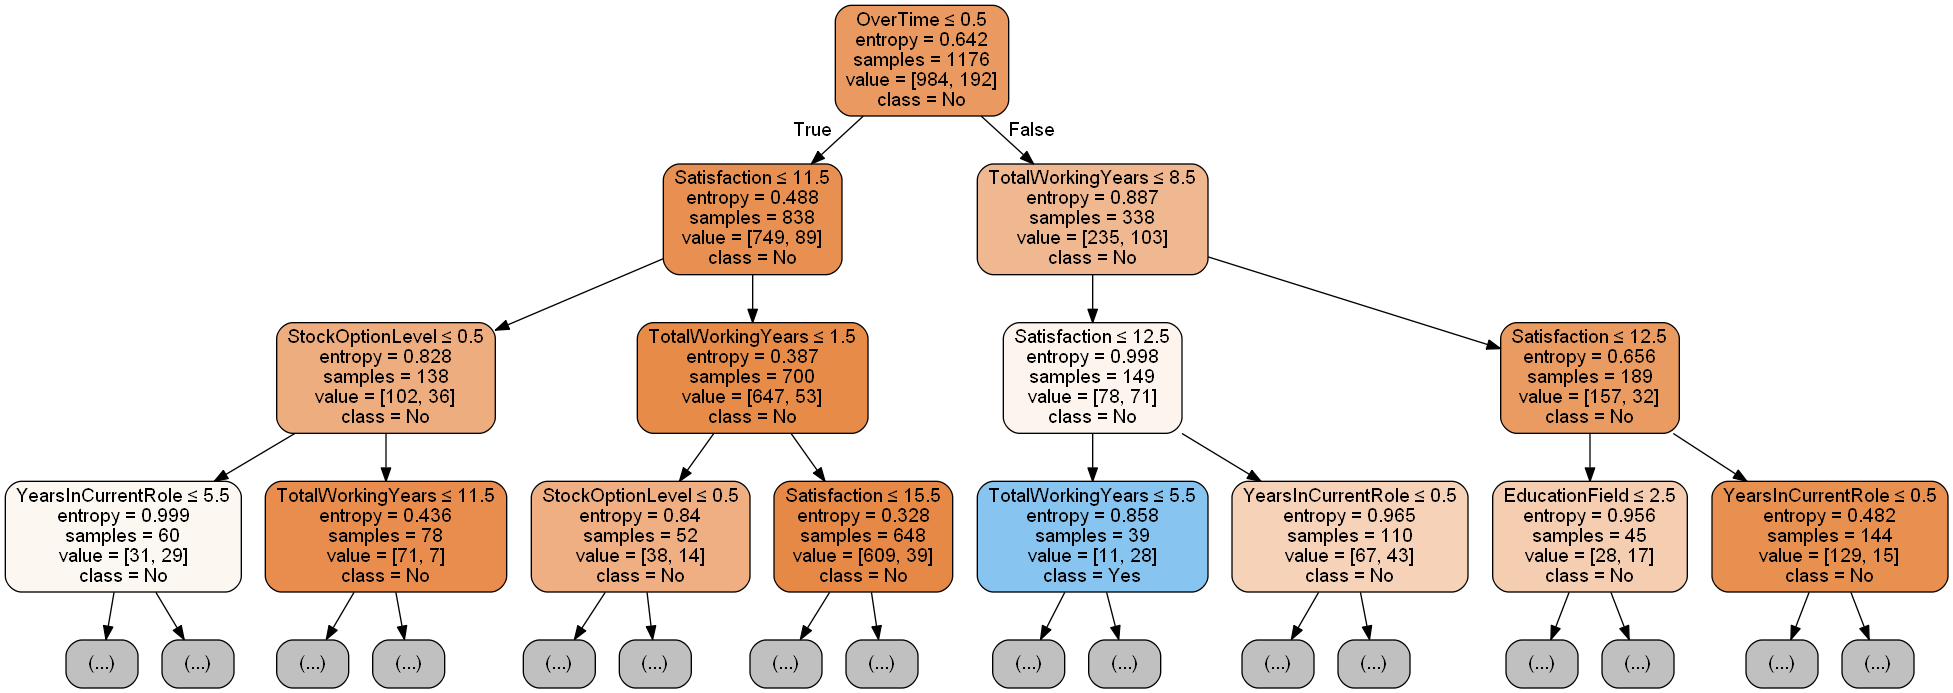

In [100]:
dot_data = tree.export_graphviz(clf_sub, out_file=None,
                                feature_names=['OverTime','StockOptionLevel','TotalWorkingYears','YearsInCurrentRole',
                      'Satisfaction','StockOptionLevel','PercentSalaryHike','EducationField'],
                                class_names=['Yes' if x == 1 else 'No' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [42]:
Y_pred_sub = clf_sub.predict(X_train_sub)

In [43]:
print('Accuracy %s' % balanced_accuracy_score(Y_train, Y_pred_sub))
print('F1-score %s' % f1_score(Y_train, Y_pred_sub, average=None))


Accuracy 0.7468241869918699
F1-score [0.85808219 0.5085389 ]


In [44]:
print(classification_report(Y_train, Y_pred_sub))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       984
           1       0.40      0.70      0.51       192

    accuracy                           0.78      1176
   macro avg       0.67      0.75      0.68      1176
weighted avg       0.84      0.78      0.80      1176



In [45]:
confusion_matrix(Y_train, Y_pred_sub)

array([[783, 201],
       [ 58, 134]], dtype=int64)

In [48]:
scores = cross_val_score(clf_sub, X_train, Y_train, cv=StratifiedKFold(15),scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_sub, X_train, Y_train, cv=StratifiedKFold(15), scoring='f1')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_sub, X_train, Y_train, cv=StratifiedKFold(15), scoring='roc_auc')
print('Roc_auc: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_sub, X_train, Y_train, cv=StratifiedKFold(15), scoring='recall')
print('Recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_sub, X_train, Y_train, cv=StratifiedKFold(15), scoring='precision')
print('Precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.7325 (+/- 0.15)
F1-score: 0.4732 (+/- 0.16)
Roc_auc: 0.7697 (+/- 0.17)
Recall: 0.7201 (+/- 0.31)
Precision: 0.3545 (+/- 0.12)


# predicting test

In [81]:
Y_pred = clf.predict(X_test)

In [83]:
print('Train Accuracy %s' % balanced_accuracy_score(Y_train, Y_pred_tr))
print('Train F1-score %s' % f1_score(Y_train, Y_pred_tr, average='binary'))
print('Train Roc_auc %s' % roc_auc_score(Y_train, Y_pred_tr))
print('Train Recall %s' % recall_score(Y_train, Y_pred_tr))
print('Train Precision %s' % precision_score(Y_train, Y_pred_tr))

Train Accuracy 0.752223069105691
Train F1-score 0.5261044176706827
Train Roc_auc 0.7522230691056909
Train Recall 0.6822916666666666
Train Precision 0.42810457516339867


In [47]:
print('Test Accuracy %s' % balanced_accuracy_score(Y_test, Y_pred))
print('Test F1-score %s' % f1_score(Y_test, Y_pred, average='binary'))
print('Test Roc_auc %s' % roc_auc_score(Y_test, Y_pred))
print('Test Recall %s' % recall_score(Y_test, Y_pred))
print('Test Precision %s' % precision_score(Y_test, Y_pred))

Test Accuracy 0.7186077643908969
Test F1-score 0.49056603773584895
Test Roc_auc 0.7186077643908969
Test Recall 0.5777777777777777
Test Precision 0.4262295081967213


In [48]:
le=LabelEncoder()
by_test=le.fit_transform(Y_test)
by_pred=le.fit_transform(Y_pred)

In [49]:
fpr, tpr, _ = roc_curve(by_test, by_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc

0.7186077643908969


0.7186077643908969

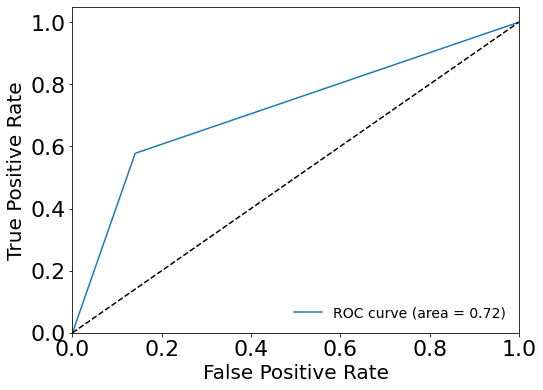

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

<Figure size 2880x2160 with 0 Axes>

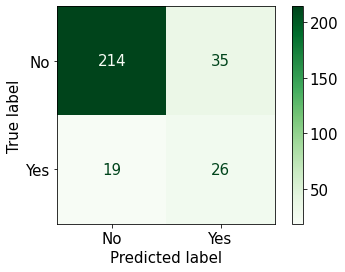

In [80]:
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title
plt.figure(figsize=(40, 30))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, Y_test,
                                 display_labels=['Yes' if x == 1 else 'No' for x in clf.classes_],
                                 cmap=plt.cm.Greens)
plt.show()

# K-NN

In [127]:
from sklearn.neighbors import KNeighborsClassifier

In [117]:
param_list={'n_neighbors':list(np.arange(2,50)),
            'weights':['distance','uniform'],
            'p':[1,2]
            }

scoring= {'auc':'roc_auc', 'accuracy':'balanced_accuracy', 'f1':'f1'}

clf = KNeighborsClassifier(n_neighbors=5)

In [118]:
grid_search=GridSearchCV(clf, param_grid=param_list, scoring=scoring, refit='f1', cv=10)
grid_search.fit(X_train, Y_train)
clf = grid_search.best_estimator_

In [119]:
report(grid_search.cv_results_, n_top=5)

Model with rank: 1
Mean validation F1: 0.225 (std: 0.062)
Mean validation Balanced Accuracy: 0.542 (std: 0.034)
Mean validation Roc: 0.546 (std: 0.054)
Parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}

Model with rank: 2
Mean validation F1: 0.160 (std: 0.104)
Mean validation Balanced Accuracy: 0.526 (std: 0.044)
Mean validation Roc: 0.555 (std: 0.061)
Parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

Model with rank: 3
Mean validation F1: 0.198 (std: 0.103)
Mean validation Balanced Accuracy: 0.524 (std: 0.059)
Mean validation Roc: 0.541 (std: 0.057)
Parameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

Model with rank: 4
Mean validation F1: 0.157 (std: 0.094)
Mean validation Balanced Accuracy: 0.524 (std: 0.042)
Mean validation Roc: 0.558 (std: 0.063)
Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

Model with rank: 5
Mean validation F1: 0.151 (std: 0.097)
Mean validation Balanced Accuracy: 0.523 (std: 0.041)
Mean validation Roc: 0.555 (

In [128]:
clf = KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

In [129]:
clf = clf.fit(X_train, Y_train)

In [130]:
Y_pred = clf.predict(X_test)

In [131]:
print('Accuracy %s' % accuracy_score(Y_test, Y_pred))
print('F1-score %s' % f1_score(Y_test, Y_pred, average=None))
print(classification_report(Y_test, Y_pred))
confusion_matrix(Y_test, Y_pred)

Accuracy 0.7585034013605442
F1-score [0.85996055 0.12345679]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       249
           1       0.14      0.11      0.12        45

    accuracy                           0.76       294
   macro avg       0.49      0.49      0.49       294
weighted avg       0.74      0.76      0.75       294



array([[218,  31],
       [ 40,   5]], dtype=int64)

In [132]:
scores = cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(15),scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

 

scores = cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(15), scoring='f1')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

 

scores = cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(15), scoring='roc_auc')
print('Roc_auc: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

 

scores = cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(15), scoring='recall')
print('Recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

 

scores = cross_val_score(clf, X_train, Y_train, cv=StratifiedKFold(15), scoring='precision')
print('Precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.5436 (+/- 0.12)
F1-score: 0.2246 (+/- 0.21)
Roc_auc: 0.5494 (+/- 0.13)
Recall: 0.2192 (+/- 0.24)
Precision: 0.2427 (+/- 0.21)
